# Домашнее задание 5

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 17 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_5

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{2}x^T A x - b^T x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица с $L =1000$, $\mu = 1$, $d = 100$, $b$ - так же случайный вектор.

__(а)__ Для такой задачи симулируем итерацию SGD:
$$
x^{k+1} = x^k - \gamma (\nabla f(x^k) + \xi^k),
$$
где $\xi^k$ - независимая от $x^k$ случайная величина из нормального распределения $\mathcal{N}(0, 100)$.

Для такого метода с $\gamma = \frac{1}{L}$ постройте график сходимости (критерий $\| \nabla f(x^k)\|^2$). Постройте на этом же графике сходимость честного градиентного спуска c $\gamma = \frac{1}{L}$. Сделайте вывод о характере сходимости нового метода.

In [1]:
import my_optimization as opt
import numpy as np

In [2]:
L, mu, d = 1000, 1, 100
n_iter  = 10000
A = opt.gen_A(d, mu, L)
b, x_0 = np.random.normal(20, 10, d), np.random.normal(0, 10, d)
lr = 1/L

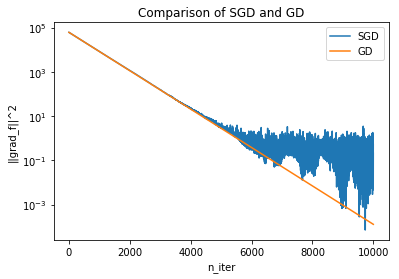

In [3]:
iterations = [i + 1 for i in range(n_iter)]
SGD_points = opt.Grad_Optimizer(n_iter, A, lr, b, x_0, optimizer = "SGD")
GD_points = opt.Grad_Optimizer(n_iter, A, lr, b, x_0, optimizer = "GD")
SGD_criteria_points = opt.criteria_points(A, b, SGD_points, criteria_type = "||grad_f||^2")
GD_criteria_points = opt.criteria_points(A, b, GD_points, criteria_type = "||grad_f||^2")
y = [SGD_criteria_points, GD_criteria_points]
label = ["SGD", "GD"]

opt.plot_graphs(iterations, y, label, "Comparison of SGD and GD", logscale = True, criteria_type = "||grad_f||^2")

__(б)__ На семинаре обсуждались способы борьбы со "стохастичностью" сходимости градиентного спуска. В частности, мы затронули использование уменьшающегося шага (смотри, например, Теорему 5 из [работы](https://arxiv.org/pdf/1907.04232.pdf)), а также использование батчирования (в нашем случае это просто замена: $\xi^k \to \frac{1}{b} \sum\limits_{i=1}^b \xi^k_i$, где $\xi^k_i \in \mathcal{N}(0, 100)$ и независимы). Реализуйте эти модификации (для батчирования возьмите $b = 10 , 100$). Добавьте полученные результаты на график сходимости из пункта (а). Постройте также график сходимости, где по оси $x$ будет не количество итераций, а количество генераций $\xi^k_i$ (количество вызовов стохастического градиента).

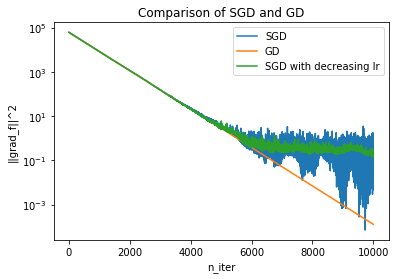

In [4]:
#Theorem 5
SGD_points_lr_decrease = opt.Grad_Optimizer(n_iter, A, lr, b, x_0, optimizer = "SGD", lr_decrease = True, 
                   a = mu, d = L)
SGD_criteria_points_lr_decrease = opt.criteria_points(A, b, SGD_points_lr_decrease, criteria_type = "||grad_f||^2")

y.append(SGD_criteria_points_lr_decrease)
label.append("SGD with decreasing lr")

opt.plot_graphs(iterations, y, label, "Comparison of SGD and GD", 
                logscale = True, criteria_type = "||grad_f||^2")

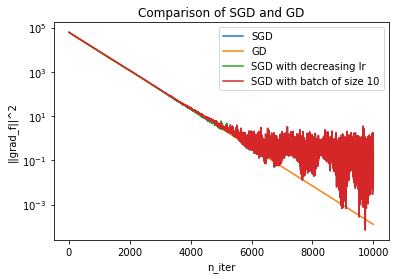

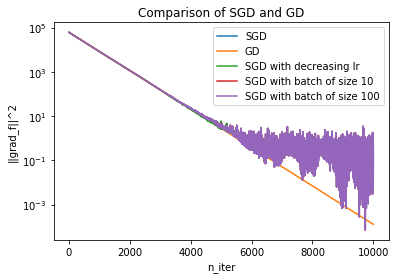

In [5]:
#Batches
b_arr = [10, 100]
for batch_size in b_arr:
    SGD_points_batch = opt.Grad_Optimizer(n_iter, A, lr, b, x_0, optimizer = "SGD", batch_size = batch_size)
    SGD_criteria_points_batch = opt.criteria_points(A, b, SGD_points, criteria_type = "||grad_f||^2")
    y.append(SGD_criteria_points_batch)
    label.append("SGD with batch of size {0}".format(batch_size))
    opt.plot_graphs(iterations, y, label, "Comparison of SGD and GD", logscale = True, criteria_type = "||grad_f||^2")

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). Как мы знаем, эта задача имеет вид конечной суммы:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{n} \sum\limits_{j=1}^n f_j(w) := \frac{1}{n} \sum\limits_{j=1}^n \left[\frac{1}{b} \sum\limits_{i=1}^b f_{ji}(w)\right] := \frac{1}{n} \sum\limits_{j=1}^n \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_i), y_i)\right],
\end{equation}
где $nb = N$ - полный размер выборки. Решите данную задачу с помощью SGD, SAGA (секция А.5 из [работы](https://arxiv.org/pdf/1905.11261.pdf)), SVRG (секция А.9 из [работы](https://arxiv.org/pdf/1905.11261.pdf)) и SARAH ([работа](https://arxiv.org/pdf/1703.00102.pdf)). 

__(а)__ Оцените $\mu$ и $L$ для данной задачи. Обратите внимание, что теория для SAGA, SVRG, SARAH предполагает, что $L$ - это константа Липшица градиентов $\nabla f_j$. 

$$\mu = 0$$

$$L = \dfrac{1}{4} \cdot \underset{i \in \overline{1, N}}{\max}\left\{\lambda_{\max} \left[x^i (x^i)^T\right]\right\}$$

__(б)__ Реализуйте SGD, SAGA, SVRG, SARAH для задачи логистической регресии из $n$ слагаемых, где каждое слагаемое так же имеет виды суммы размеры $b$. Каким надо взять $b$? Почему? Что об этом говорит теория? Как будете выбирать шаг и другие параметры методов?

In [7]:
#SGD

In [ ]:
#SAGA

In [ ]:
#SVRG

In [ ]:
#SARAH

__(в)__ Постройте графики сравнения всех методов: по оси $x$ используйте время или количество подсчетов $\nabla f_{ji}$, по оси $y$ - $\|\nabla f(w^k)\|$ или точность на тесте. Таким образом, всего 4 графика. Сделайте сравнение и вывод.

In [8]:
#ответ

__Бонусные пункты__

__(г)__ Методы SGD, SAGA, SVRG, SARAH, которые мы рассматривали, предполагают случайный выбор индекса на каждой итерации. Но между тем, на практике обычно делают по-другому и просто последовательно меняют $i_k$ от $1$ до $n$ (а потом заново). В [работе](https://arxiv.org/abs/2006.05988) изучаются такие подходы. Реализуйте Random Reshuffling и Shuffle Once для SGD и SARAH. Сравните новые алгоритмы со старыми версиями SGD и SARAH из пунктов (б) и (в).

In [9]:
#ответ

__(д)__ Методы SVRG и SARAH имеют loopless версии: L-SVRG (секция А.10 из [работы](https://arxiv.org/pdf/1905.11261.pdf) и PAGE ([работа](https://proceedings.mlr.press/v139/li21a.html)), соотвественно. Реализуйте их. Как будете выбирать вероятности в этих алгоритмах? Сравните новые алгоритмы со старыми версиями SVRG и SARAH из пунктов (б) и (в).

In [10]:
#ответ